In [80]:
import os
import qiskit
import torch
from qiskit_aer import AerSimulator
from qiskit import transpile, QuantumCircuit as QiskitQuantumCircuit
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchxrayvision as xrv
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights

In [81]:
QC_outputs = ['000', '001', '010', '011', '100', '101', '110', '111']

In [82]:
class MammoDataset(Dataset):
    def __init__(self, root_dir, train=True):
        self.image_paths = []
        self.labels = []
        
        if train:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize(256),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.RandomCrop(224),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                                       ])
        else: 
            self.transform = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                       ])

        for label in ['0', '1']:
            folder_path = os.path.join(root_dir, label)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))
                self.labels.append(int(label))

    def __len__(self):
        return len(self.labels)
    
    def get_transform(data_augmentation=True):
        if data_augmentation:
            transform = transform.Compose([transform.Resize(256),
                                        transform.RandomRotation(10)])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        #image = torch.Tensor(np.array(image))
        if self.transform:
            image = self.transform(image)

        # Converte a imagem para um tensor do PyTorch
        #image = torch.tensor(image, dtype=torch.float32)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [83]:
# class DenseNetNN(nn.Module):
#     def __init__(self, *args, **kwargs):
#         super(DenseNetNN, self).__init__()
#         self.model = xrv.models.DenseNet(weights="all").features
#         #self.embedding_layer = nn.Linear(1024, 128)

#     def forward(self, x):
#         x1 = self.model(x)

#         return x1

In [84]:
class Resnet(torch.nn.Module):
    def __init__(self, out_features = 1024):
        super(Resnet, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, out_features)
    def forward(self, x):
        return self.resnet(x)

In [85]:
# Defines the quantum circuit
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        # Define how many qubits we want
        self._circuit = QiskitQuantumCircuit(n_qubits)

        # List of qubits
        all_qubits = [i for i in range(n_qubits)]

        # Define 7 placeholder variables
        self.theta_0 = qiskit.circuit.Parameter('theta0')
        self.theta_1 = qiskit.circuit.Parameter('theta1')
        self.theta_2 = qiskit.circuit.Parameter('theta2')
        self.theta_3 = qiskit.circuit.Parameter('theta3')
        self.theta_4 = qiskit.circuit.Parameter('theta4')
        self.theta_5 = qiskit.circuit.Parameter('theta5')
        self.theta_6 = qiskit.circuit.Parameter('theta6')

        # Build the circuit
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta_0, all_qubits)
        self._circuit.cz(0, 1)
        self._circuit.cz(1, 2)
        self._circuit.ry(self.theta_1, 0)
        self._circuit.ry(self.theta_2, 1)
        self._circuit.ry(self.theta_3, 2)
        self._circuit.cz(0, 1)
        self._circuit.cz(1, 2)
        self._circuit.ry(self.theta_4, 0)
        self._circuit.ry(self.theta_5, 1)
        self._circuit.ry(self.theta_6, 2)
        self._circuit.measure_all()

        # Save these variables for later use
        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        # Bind parameters to the circuit
        param_values = {
            self.theta_0: thetas[0],
            self.theta_1: thetas[1],
            self.theta_2: thetas[2],
            self.theta_3: thetas[3],
            self.theta_4: thetas[4],
            self.theta_5: thetas[5],
            self.theta_6: thetas[6]
        }

        # Create a bound circuit
        bound_circuit = self._circuit.assign_parameters(param_values)

        # Transpile the circuit for the specified backend
        transpiled_circuit = transpile(bound_circuit, self.backend)

        # Run the circuit
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()

        # Get the counts and compute the expected values
        counts = result.get_counts(transpiled_circuit)

        expects = np.zeros(8)
        for k in range(8):
            key = QC_outputs[k]
            perc = counts.get(key, 0) / self.shots
            expects[k] = perc
        return expects

In [86]:
#This class defines what our hybrid layer does. It allows it to go forward, and also backprop
class HybridFunction(Function):

  @staticmethod
  def forward(ctx, input, quantum_circuit, shift):
    ctx.shift = shift
    ctx.quantum_circuit = quantum_circuit

    parameter = []

    #A very scrapy but functional way of loading the parameters in this format
    for x in input:
      for y in x:
        parameter.append(float(y))
    # print(parameter)

    #Aka we run the input into our circuit
    expectation_z = ctx.quantum_circuit.run(parameter) #Might need to change this when have multi-layer
    #Shoves to pytorch tesnor
    result = torch.tensor([expectation_z])
    #Save the input and result for backpropagation
    ctx.save_for_backward(input,result)
    #return output
    return result
  
  @staticmethod
  def backward(ctx, grad_output):
    #Regrabing the input and the output
    input, expectation_z = ctx.saved_tensors
    # input_list = np.array(input.tolist())
    # print(input)

    input_list = list(input)[0]
    # print(input_list)

    input_list = input_list.cpu()

    #A list of all the gradients
    gradients = torch.Tensor()

    #We're going to go through the inputs and then calculate the gradient for each one
    for i in range(7):
      #In order to get the gradients for each one, we shift one of the parameters a tiny bit and find the difference in the outputs... Since we can't do backprop on it, we use something called shift parameter
      shift_right = np.array(input_list.detach().clone())
      shift_left = np.array(input_list.detach().clone())
      shift_right[i] = shift_right[i] + ctx.shift
      shift_left[i] = shift_left[i] - ctx.shift

      #So we take the shifted ones and just compute it 
      expectation_right = ctx.quantum_circuit.run(shift_right)
      expectation_left  = ctx.quantum_circuit.run(shift_left)
      #Gradient = appox the difference (division by 2*shift isn't necessary since it'll just be a scaled version (which can be counteracted by lr))
      gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
      #Append the gradient to the meta list
      gradients  = torch.cat((gradients, gradient.float()))
    
    #Format everything
    result = torch.Tensor(gradients)
    result = result.float()
    result = result.T

    #Just a random varaible that made my life easier when debugging
    Fixer = grad_output.float()
    Fixer = Fixer.T

    #Find the gradients at last!!!
    h = result * Fixer
    h = h.cuda()
    #then return it for backprop
    return h, None, None
     

In [87]:
class Hybrid(nn.Module):
    # Initialization
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        # Define the real quantum circuit that we'll be using for our thing
        self.quantum_circuit = QuantumCircuit(16, backend, shots)
        # Save this guy for later
        self.shift = shift

    # When forwarding
    def forward(self, input):
        batch_results = []
        for i in range(input.shape[0]):
            result = HybridFunction.apply(input[i].unsqueeze(0), self.quantum_circuit, self.shift)
            batch_results.append(result)
        return torch.cat(batch_results)

In [88]:
class Net(nn.Module):
    def __init__(self):
            super(Net, self).__init__()
            self.classical = Resnet()
            self.middle = nn.Sequential(
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.ReLU(),
                nn.Linear(256, 7)
            )
            sim = AerSimulator()
            self.quant = Hybrid(sim, 1000, np.pi / 2)
            self.end = nn.Sequential(
                nn.Linear(8, 1),
                # nn.Sigmoid()
            )
 
    def forward(self, x):
        x = self.classical(x)
        x = nn.Flatten(start_dim=1)(x)
        x = self.middle(x)
        theta = x 
        x = self.quant(x)
        x = x.type(dtype=torch.cuda.FloatTensor)
        x = self.end(x.float())
        x = nn.Flatten(start_dim=1)(x)
        return x, theta 

In [89]:
train_dir = 'C:\\Users\\Win10\\PycharmProjects\\QuantumResearch\\INbreast\\data\\png\\train'
test_dir = 'C:\\Users\\Win10\\PycharmProjects\\QuantumResearch\\INBreast\\data\\png\\test'

# Instancia os datasets
train_dataset = MammoDataset(root_dir=train_dir)
test_dataset = MammoDataset(root_dir=test_dir, train=False)

# Cria os DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [91]:
model = Net().cuda()
loss_func = nn.BCEWithLogitsLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 3
loss_list = []
thetas = []

In [92]:
model.train()
for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (image, label) in enumerate(train_loader):
        label = label.unsqueeze(1)
        
        # Converta os tensores para o tipo correto
        image = image.cuda()
        label = label.cuda().type(torch.cuda.FloatTensor)

        optimizer.zero_grad()  # Zere os gradientes

        # Passe as imagens pelo modelo
        prediction, theta = model(image)

        # Calcule a perda
        loss = loss_func(prediction, label)

        # Propagação para trás e atualização dos pesos
        loss.backward()
        optimizer.step()

        # Armazene as informações
        thetas.append(theta)
        total_loss.append(loss.item())
        print(f"  Batch {batch_idx + 1} concluído com loss: {loss.item():.4f}")
        
    avg_loss = np.mean(total_loss)
    loss_list.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

    model_save_path = f"model_epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)

In [ ]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for image, label in test_loader:
        image, label = image.type(dtype=torch.cuda.FloatTensor), label.type(dtype=torch.cuda.LongTensor)
        try:
            prediction, _ = model(image)
            predicted_class = prediction.argmax(dim=1)
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_class.cpu().numpy())
        except:
            continue
        print(label, predicted_class)

# Calcular acurácia
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Acurácia: {accuracy:.4f}")

Acurácia: 0.6951


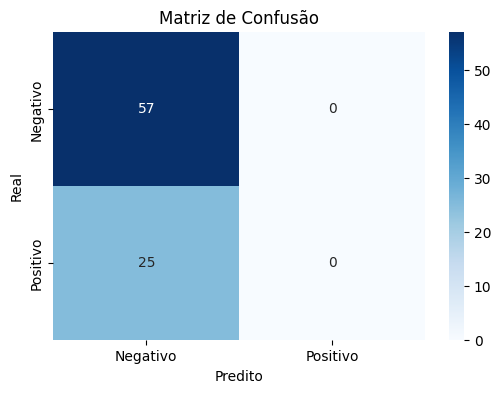

In [ ]:
# Gerar matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()